In [73]:
import pymc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import scipy.stats
import seaborn as sns
from IPython.core.pylabtools import figsize
%matplotlib inline
sns.set_style("white")

# simulate data

In [83]:
ploidy = 4
n_ind = 50
n_loci = 1
mean_depth = 25
epsilon = 0.01
allele_freqs = np.random.random(n_loci)
allele_freqs

array([ 0.63033354])

### genotypes

In [84]:
def generate_genotype(afreq, ploidy):
    genotype = np.sum(np.random.random(ploidy) < afreq)
    return(genotype)
def generate_genotype_df(allele_freqs, n_ind, ploidy):
    my_df = pd.DataFrame([[generate_genotype(afreq, ploidy) for ind in range(n_ind)] for afreq in allele_freqs]).T
    return(my_df)

In [85]:
sim_genotypes = generate_genotype_df(allele_freqs, n_ind = n_ind, ploidy = ploidy)
sim_genotypes.head(10)

,0
0,2
1,2
2,2
3,2
4,3
5,2
6,4
7,3
8,3
9,3


### read depth

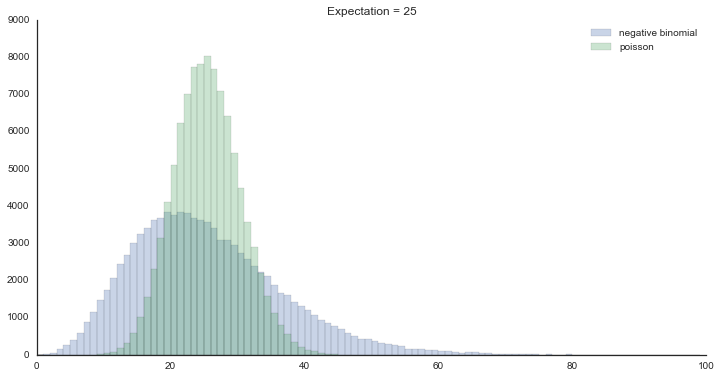

In [86]:
# use negative binomial or poisson to simulate read depth
figsize(12,6)
size = 100000
# can change dispersion parameter [0-1], close to 1 it is similar to poisson
dispersion = .2

plt.hist(np.random.negative_binomial(size = size, n=mean_depth*dispersion/(1-dispersion), p=dispersion), 
         bins = range(100), alpha = .3, label = 'negative binomial')
plt.hist(np.random.poisson(mean_depth, size = size), 
         bins = range(100), alpha = .3, label = 'poisson')
plt.title('Expectation = {}'.format(mean_depth))
plt.legend()
sns.despine()
plt.show()

#print np.mean(np.random.negative_binomial(size = size, n=mean_depth*dispersion/(1-dispersion), p=dispersion))
#print np.mean(np.random.poisson(mean_depth, size = size))

In [87]:
# one parameter function for df.applymap()
def nb(n):
    return(np.random.negative_binomial(n=mean_depth*dispersion/(1-dispersion), p=dispersion))

In [88]:
depth_df = sim_genotypes.copy()
depth_df[depth_df>-10] = mean_depth # everywhere
depth_df=depth_df.applymap(nb)
depth_df.head()

,0
0,17
1,42
2,13
3,35
4,24


### number of reads showing a1, accounting for sequencing error
could think of ways to add more noise here:
    
    1) bootstrapping?

errors are **always** wrong

In [152]:
def add_seq_error(p, epsilon):
    return(p - (p*epsilon) + (1-p)*epsilon)

__A1 depth__
mean: 13.4
variance: 68.36


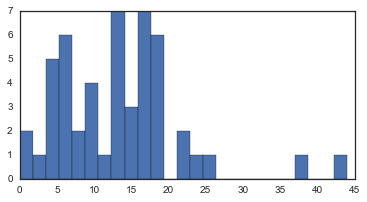

,0
0,9
1,17
2,6
3,19
4,17


In [154]:
a1_sim_depth = pd.DataFrame(np.random.binomial(n=depth_df.astype(np.int32), 
                                               p=add_seq_error(sim_genotypes/ploidy, epsilon = epsilon)))
print '__A1 depth__'
print 'mean: {}'.format(np.mean(a1_sim_depth)[0])
print 'variance: {}'.format(np.var(a1_sim_depth)[0])
plt.hist(a1_sim_depth.values, bins = n_ind/2)
plt.show()
a1_sim_depth.head()

In [ ]:
a1_sim_depth = pd.DataFrame(np.random.binomial(n=depth_df.astype(np.int32), 
                                               p=add_seq_error(sim_genotypes/ploidy, epsilon = epsilon)))

## model

In [155]:
# constants
ploidy = 4
epsilon = .01
# allele depth, take from simulation above
total_depth = depth_df.values
a1_depth = a1_sim_depth.values

# book keeping
assert len(total_depth) == len(a1_depth)
N = len(total_depth)

# priors
# prior on population freq
pop_freq = pymc.Beta('pop_freq', 1, 1) # flat
#epsilon = pymc.Beta('epsilon', 1.01, 100)


# each genotype is drawn as a binomial from the pop_freq
# genotypes are scored as the number of a1 alleles
genotypes = np.empty(N, dtype=object)
for i in range(N):
    genotypes[i] = pymc.Binomial('geno_{}'.format(i), n=ploidy, p = pop_freq,
                             value = (a1_depth/total_depth)[i], observed = False)

# turn genotypes into the chace each allele is a1
prob_a1x = genotypes / np.float(ploidy)
# account for seq errors 
prob_a1 = add_seq_error(p = prob_a1x, epsilon = epsilon)

# use the likelihood of the data to determine the genotype
a1_reads = np.empty(N, dtype=object)
for i in range(N):
    a1_reads[i] = pymc.Binomial('reads_{}'.format(i), n=total_depth[i], 
                             p = prob_a1[i],
                             value = a1_depth[i], observed = True)
    
model1 = dict(pop_freq=pop_freq, genotypes=genotypes, prob_a1=prob_a1, epsilon = epsilon )

## MCMC sampling

In [156]:
S = pymc.MCMC(model1)
S.sample(iter=50000, burn=500)
#S.stats()

 [-----------------100%-----------------] 50000 of 50000 complete in 452.7 sec

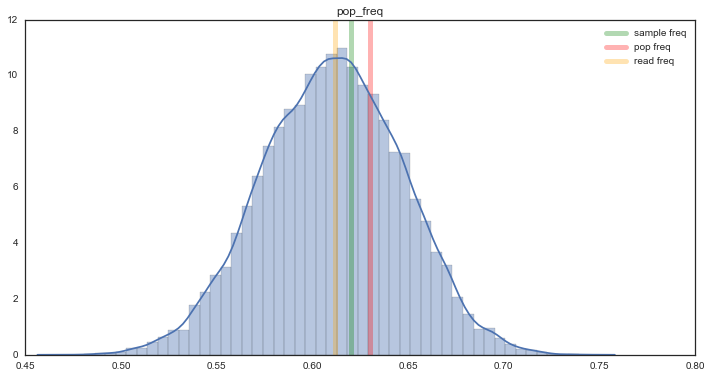

In [157]:
figsize(12,6)
# actual freq
plt.axvline(x=(sim_genotypes.mean(0)/ploidy).values, 
            lw = 5, alpha = .3, color = 'green', label ='sample freq') # sample frequency

plt.axvline(x=allele_freqs, 
            lw = 5, alpha = .3, color = 'red', label ='pop freq') # simulation frequency

plt.axvline(x=(a1_sim_depth/ depth_df).mean().values, 
            lw = 5, alpha=0.3, color = 'orange', label = 'read freq') # read frequency


sns.distplot(S.trace('pop_freq')[:])
plt.title('pop_freq')
plt.legend()
plt.show()


plt.show()

In [186]:
## compare actual and estimated genotype distributions

In [158]:
yy = [S.trace('geno_{}'.format(xx))[:].flatten() for xx in range(n_ind)]
zz = [item for sublist in yy for item in sublist]

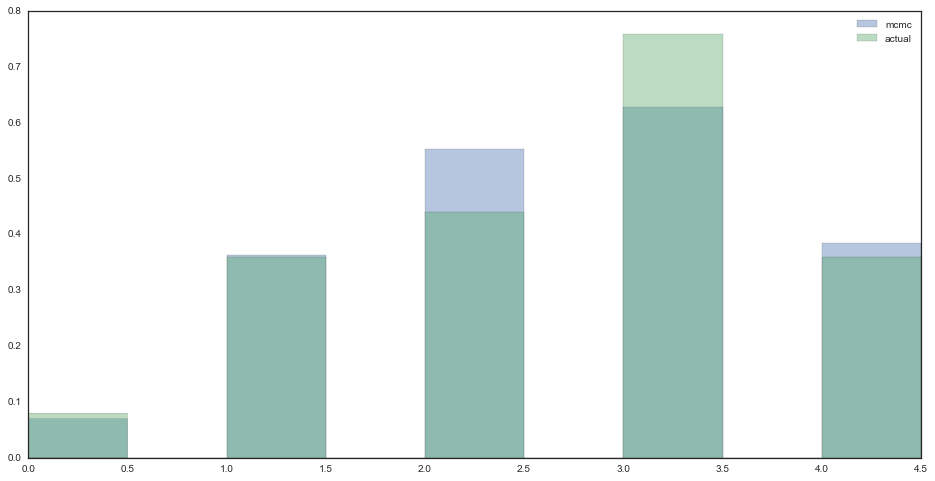

In [162]:
plt.hist(zz, bins=(np.arange(0, 5, .5)), alpha = .4, normed=True, label='mcmc')
plt.hist(sim_genotypes.values, bins=(np.arange(0, 5, .5)), alpha = .4, normed=True, label='actual')
plt.legend()
plt.show()

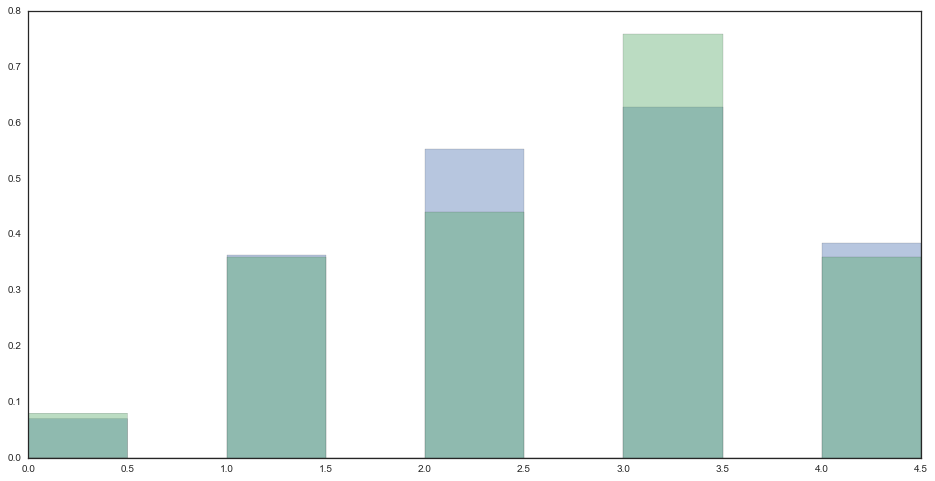

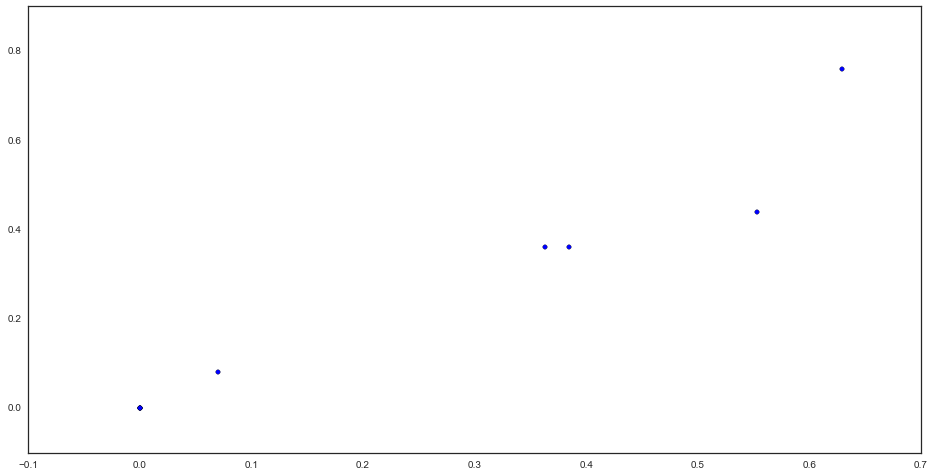

In [170]:
a = plt.hist(zz, bins=(np.arange(0, 5, .5)), alpha = .4, normed=True, label='mcmc')
b = plt.hist(sim_genotypes.values, bins=(np.arange(0, 5, .5)), alpha = .4, normed=True, label='actual')
plt.show()
plt.scatter(a[0],b[0])

In [171]:
a[0]

array([ 0.07017131,  0.        ,  0.36276768,  0.        ,  0.55307394,
        0.        ,  0.62914505,  0.        ,  0.38484202])

In [ ]:
## maybe color by the most likely

LinAlgError: singular matrix

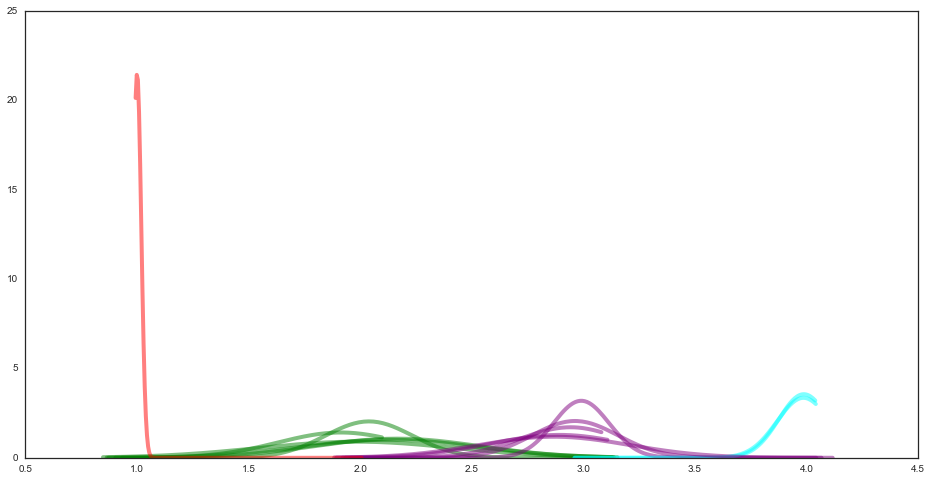

In [160]:
figsize(16,8)
colors = ['blue', 'red', 'green', 'purple', 'aqua']
for ww in yy:
    mode =  scipy.stats.mode(ww)[0][0]
    sns.distplot(ww, bins=(np.arange(0, 5, 1)), hist = False, kde=False, fit=scipy.stats.norm, norm_hist = False, 
                fit_kws = {"alpha": .5, 'color':colors[mode], "lw" : 4}, color = colors[mode])

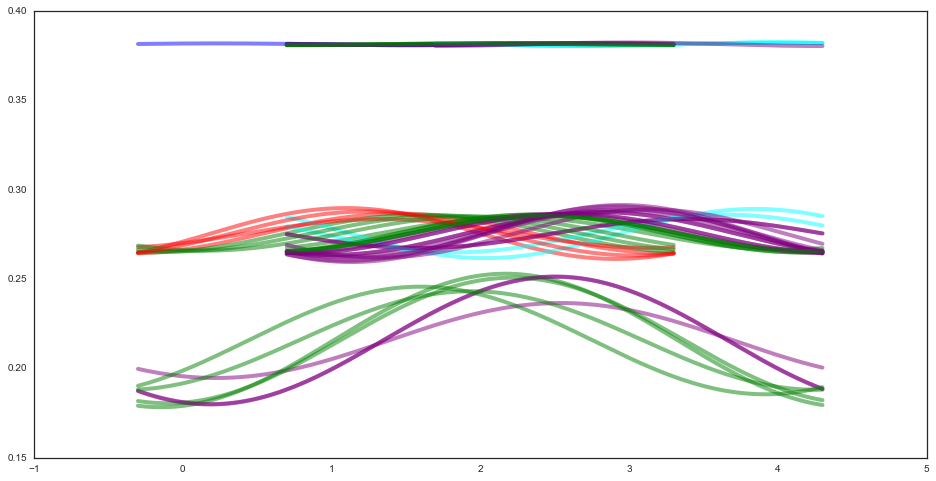

In [236]:
figsize(16,8)
colors = ['blue', 'red', 'green', 'purple', 'aqua']
for ww in yy:
    mode =  scipy.stats.mode(ww)[0][0]
    sns.distplot(ww, bins=(np.arange(0, 5, 1)), hist = False, kde=True, norm_hist = False, 
                kde_kws = {"alpha": .5, 'bw':1.5, 'cut':0.2,'color':colors[mode], "lw" : 4}, color = colors[mode])

In [ ]:
#sns.distplot(S.trace('epsilon')[:])
#plt.title('epsilon')
#a, b = 1.01, 100
#x = np.linspace(0.0, .05, 100)
#plt.plot(x, beta(a,b).pdf(x), 'k-', lw=2, label='frozen pdf')

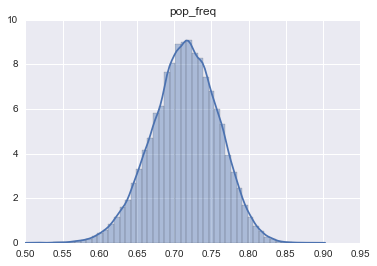

Plotting geno_2
Plotting geno_4
Plotting geno_3
Plotting geno_5
Plotting geno_6
Plotting geno_7
Plotting geno_8
Plotting geno_9
Plotting geno_10
Plotting geno_11
Plotting geno_12
Plotting geno_13
Cannot plot autocorrelation for geno_13
Plotting geno_14
Plotting geno_15
Plotting geno_16
Plotting geno_17
Plotting geno_18
Plotting geno_19
Plotting geno_20
Plotting geno_0
Plotting geno_21
Plotting geno_22
Plotting geno_23
Plotting pop_freq
Plotting geno_24
Plotting geno_25
Plotting geno_26
Plotting geno_27
Plotting geno_28
Plotting geno_29
Plotting geno_1


C:\Users\Ryan\Anaconda\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


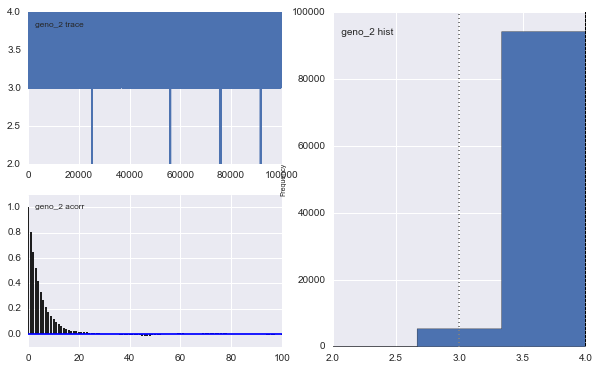

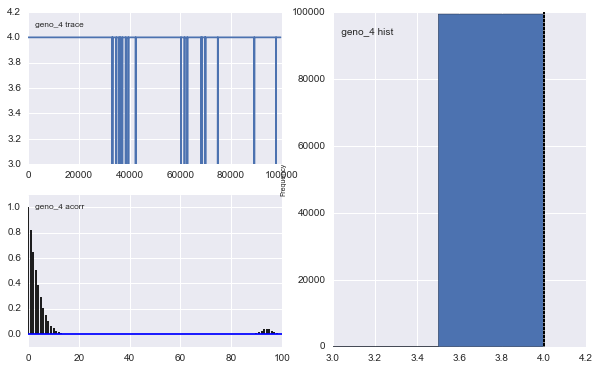

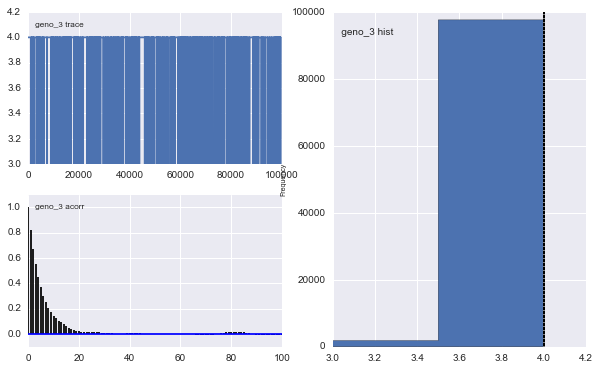

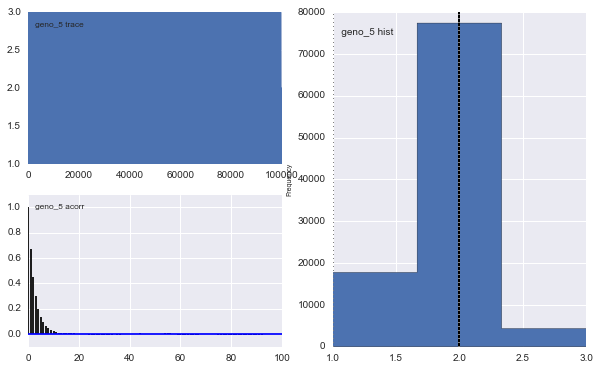

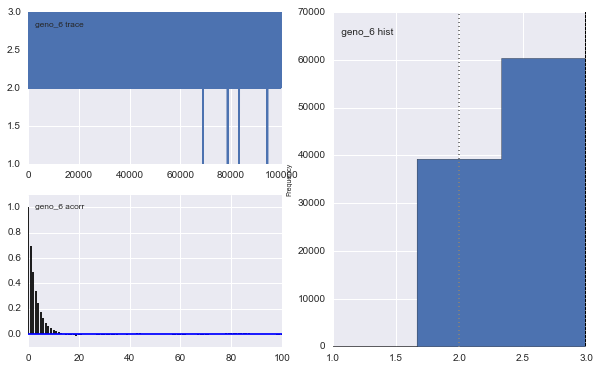

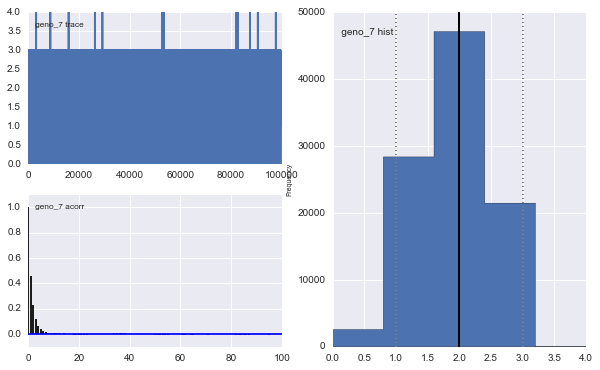

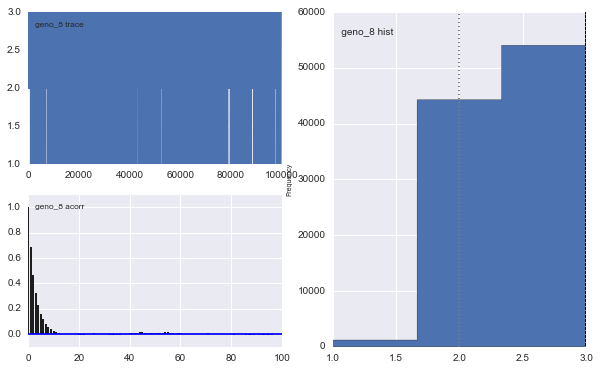

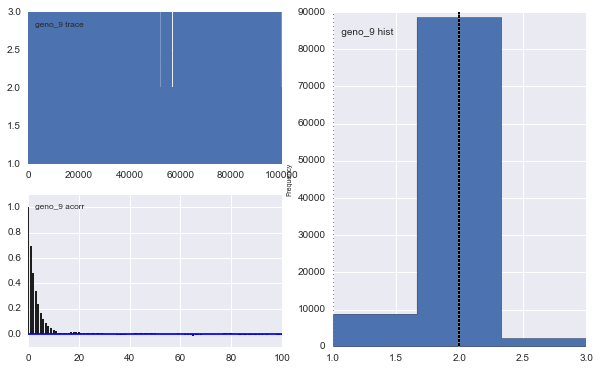

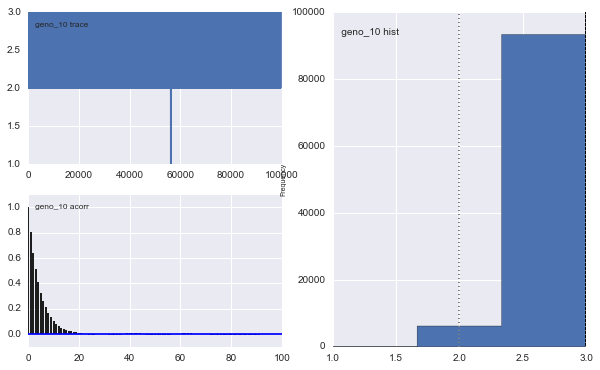

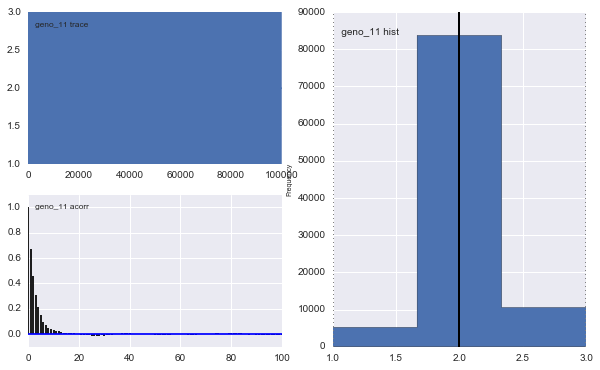

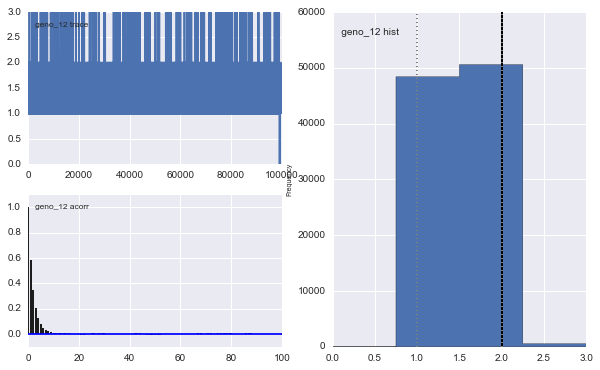

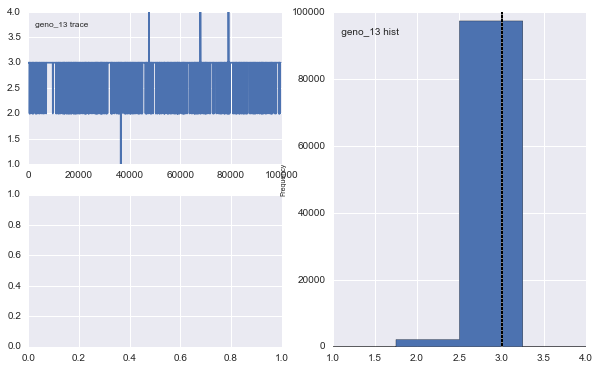

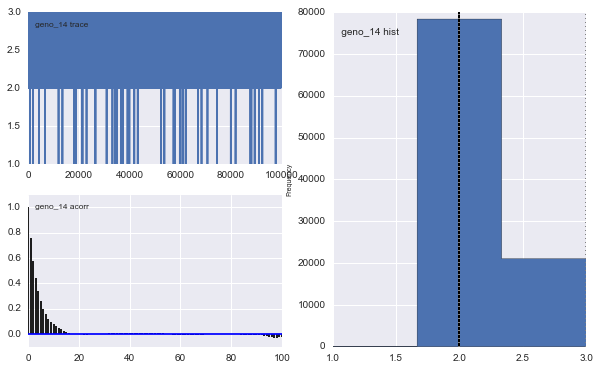

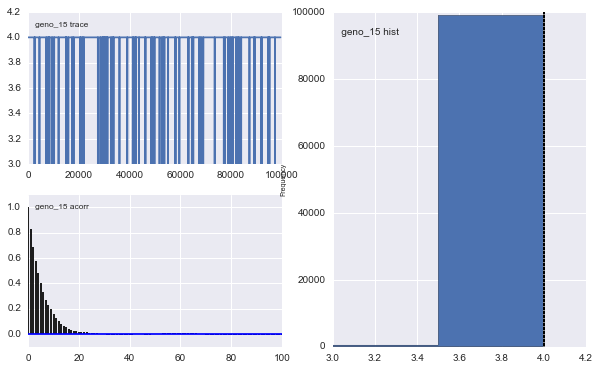

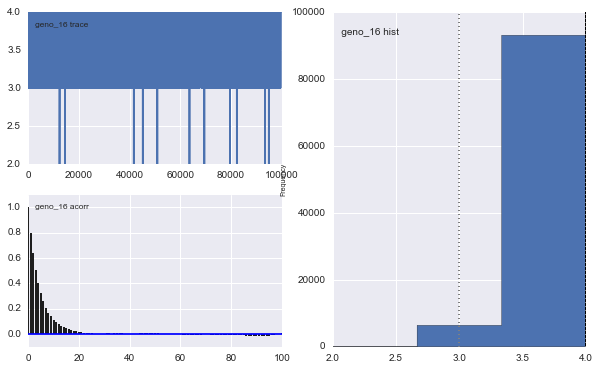

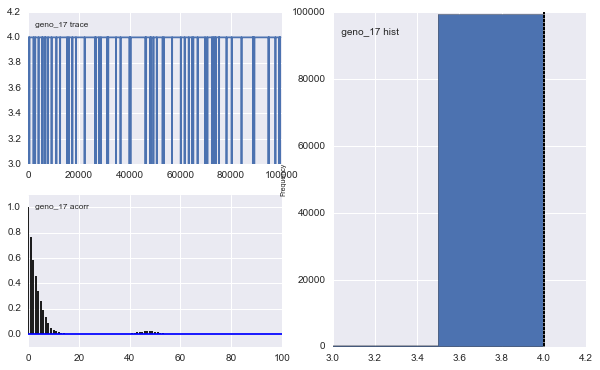

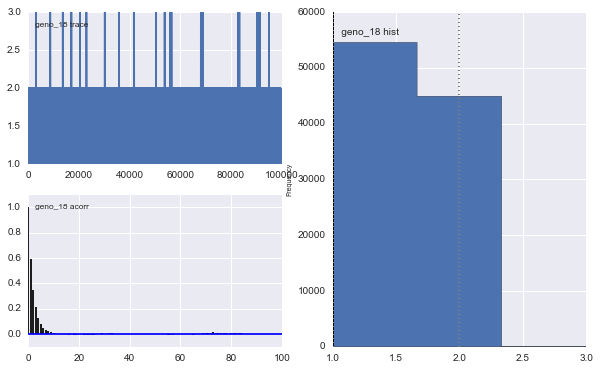

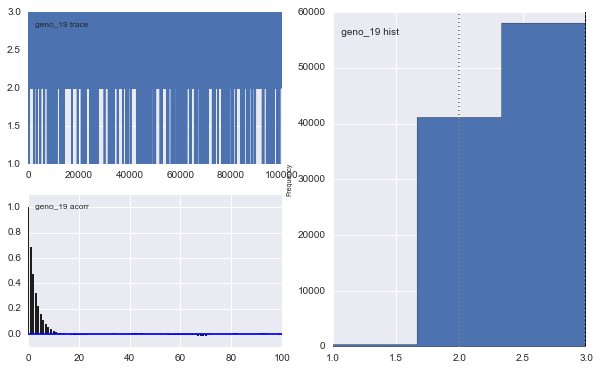

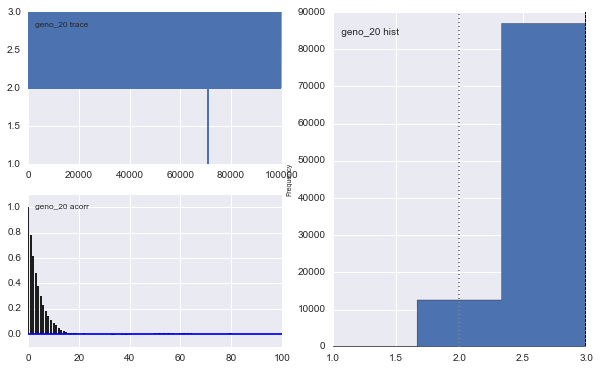

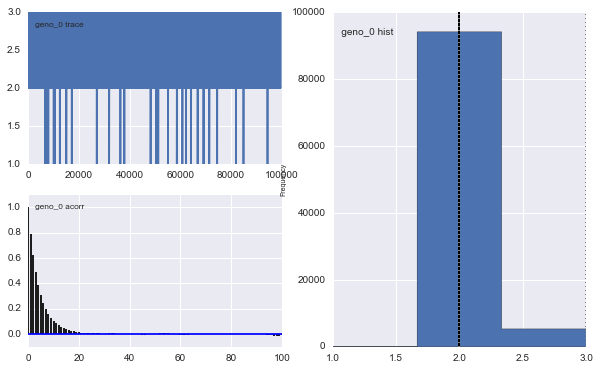

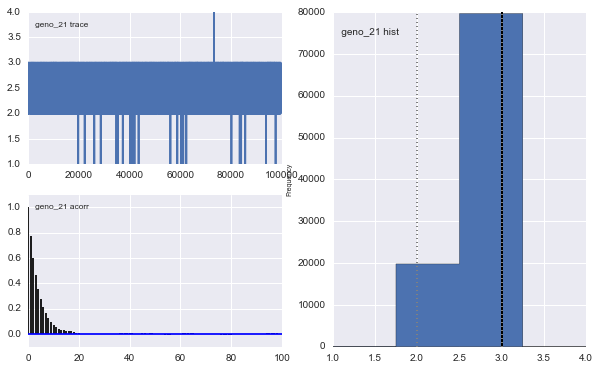

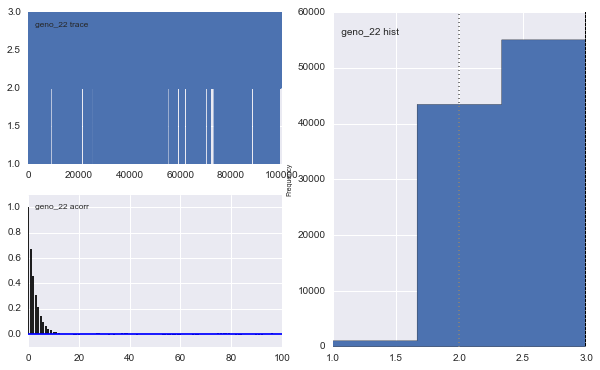

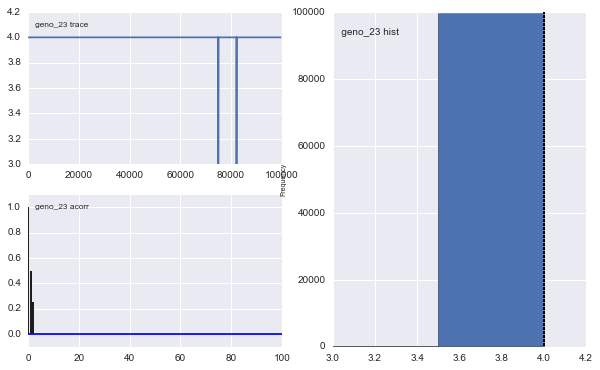

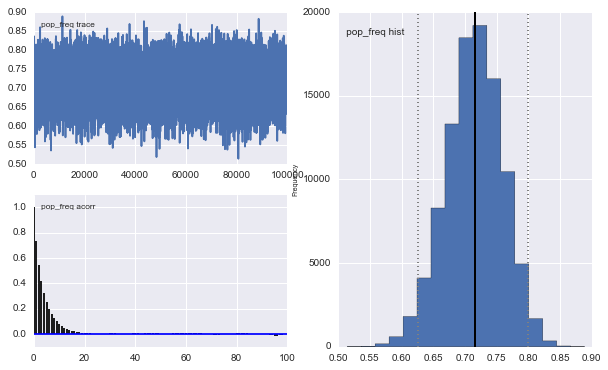

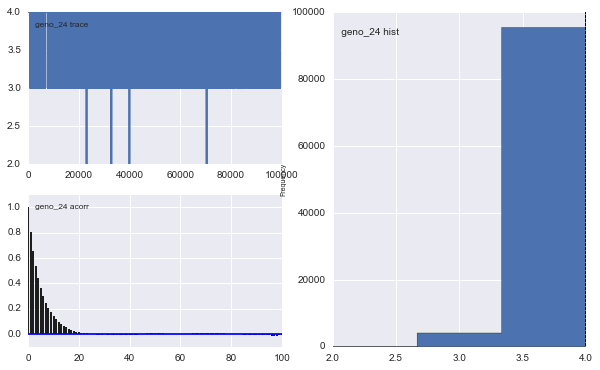

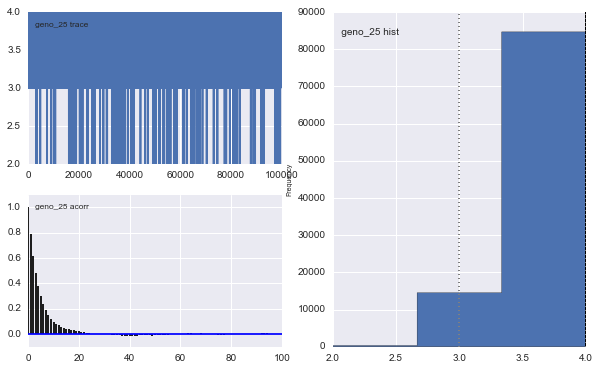

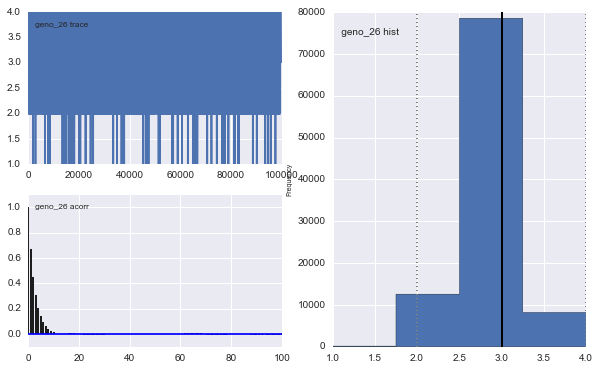

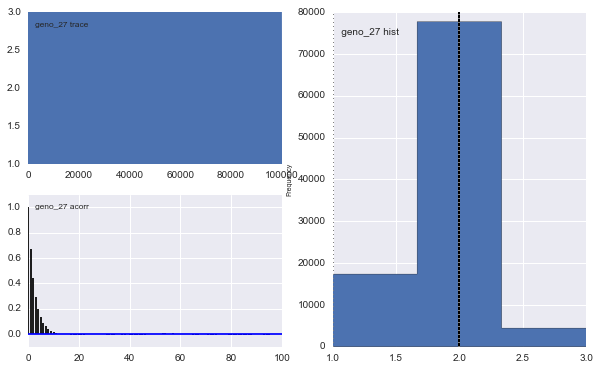

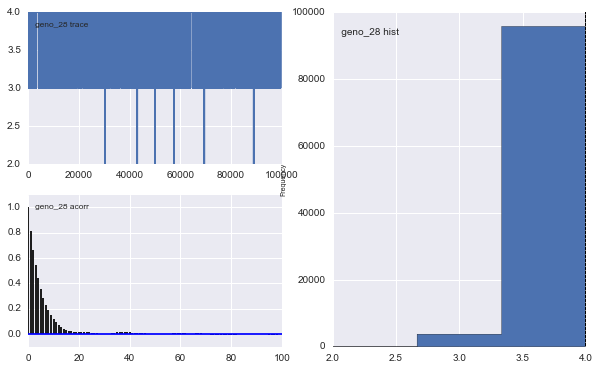

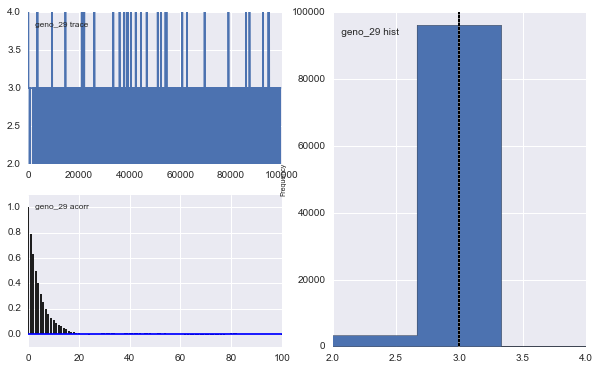

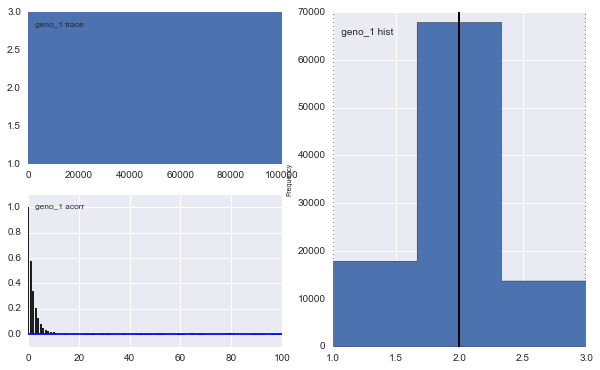

In [10]:
pymc.Matplot.plot(S)
plt.show()

In [ ]:
plt.hist(S.trace('p1')[:])
plt.title('p1')
plt.show()

In [ ]:
# data
ploidy = 4
total_depth = 16
a1_depth = 8
# chance you got it WRONG
epsilon = 0.01

@pymc.stochastic(observed=False)
def a1(value=1, ploidy = ploidy, pop_freq = pop_freq):
    return pymc.distributions.binomial_like(value, n=ploidy, p=pop_freq)

# genotype is count of a1
#a1 = pymc.Binomial('a1_genotype', ploiyd, pop_freq)
# put a prior on the error rate
#epsilon = pymc.Beta('epsilon', 1, 80)
# population freq
#pop_freq = pymc.Beta('pop_freq', 1, 1)

@pymc.deterministic
def a1(value = .5, ploidy = ploidy, pop_freq = pop_freq):
    p1_ind = a1/np.float(ploidy)
    # account for error
    p1_ind = p1_ind - (p1_ind*epsilon) + (1-p1_ind)*epsilon
    return p1_ind

# probability each read is a1
p1_ind = a1/np.float(ploidy)
# account for error
p1_ind = p1_ind - (p1_ind*epsilon) + (1-p1_ind)*epsilon


d = pymc.Binomial('d', n=total_depth[1], p = p1_ind, 
                  value = ploidy/2,
                  observed = True)

model1 = dict(a1=a1, d=d, epsilon=epsilon, p1_ind=p1_ind)
S = pymc.MCMC(model1)
S.sample(iter=100000, burn=500)

In [ ]:
# a1 is the number a1 alleles in the genotype
a1 = pymc.DiscreteUniform('a1_genotype', 0, ploidy)
# ploidy is the ploidy 
#ploidy = pymc.Degenerate('ploidy', 4, plot = False)
# chance you got it WRONG!
epsilon = pymc.Degenerate('epsilon', .01, plot = False)

# loop over individuals

# calculate 

p1 = np.empty(N, dtype=np.float)
for i in range(N):
    @pymc.deterministic(plot = True)
    def p1_now(a1=a1, epsilon=epsilon, ploidy = ploidy):
        """chance a read will show a1 allele"""
        p1 = a1/np.float(ploidy)
        # account for error
        p1 = p1 - (p1*epsilon) + (1-p1)*epsilon
        return p1
    p1[i] = p1_now

# use the likelihood of the data to determine the genotype
reads = np.empty(N, dtype=object)
for i in range(N):
    reads[i] = pymc.Binomial('x_{}'.format(i), n=total_depth[i], p = p1[i],
                             value = a1_depth[i], observed = True)

# population freq
#pop_freq = pymc.Beta('pop_freq', 1, 1)
  
# probability each read is a1

#a1_reads = pymc.Binomial('d', n=total_depth, p = p1_ind, 
#                value = a1_depth, observed = True)

In [ ]:
pymc.Matplot.plot(S)
plt.show()
plt.hist(S.trace('a1_genotype')[:])
plt.show()
plt.hist(S.trace('p1_ind')[:])
plt.show()
plt.hist(S.trace('epsilon')[:])
plt.show()

In [ ]:
assert False

mean: 0.00999900999901
var: 9.70397980399e-05
skew: 1.93153516694
kurt: 5.48475054368


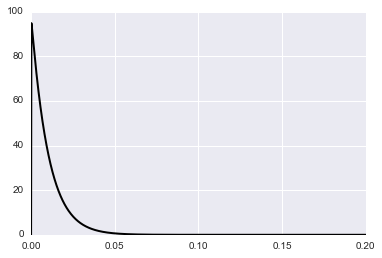

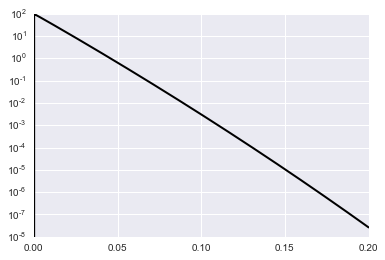

In [67]:
a, b = 1.01, 100
x = np.linspace(0.0, .2, 1000)
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
print 'mean: {}'.format(mean)
print 'var: {}'.format(var)
print 'skew: {}'.format(skew)
print 'kurt: {}'.format(kurt)
plt.plot(x, beta(a,b).pdf(x), 'k-', lw=2, label='frozen pdf')
plt.show()
plt.plot(x, beta(a,b).pdf(x), 'k-', lw=2, label='frozen pdf')
plt.yscale('log')
plt.show()

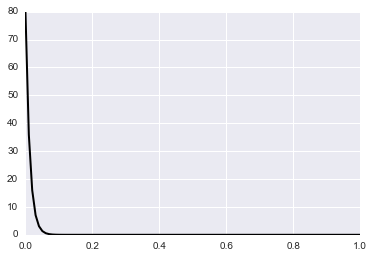

In [40]:
plt.plot(x, beta(a,b).pdf(x), 'k-', lw=2, label='frozen pdf')

In [24]:
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
print mean, var, skew, kurt

0.0123456790123 0.000148698331976 1.92726274913 5.43375645439


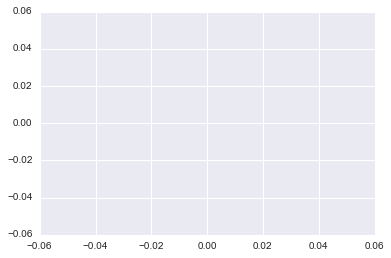

In [32]:
plt.plot(x, beta(a,b).pdf(x), 'k-', lw=2, label='frozen pdf')

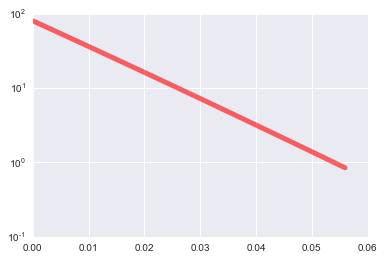

In [22]:
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
plt.plot(x, beta.pdf(x, a, b),          'r-', lw=5, alpha=0.6, label='beta pdf')
plt.yscale('log')

In [ ]:
figsize(6,3)
a, b = .5, .5
x = np.linspace(0.0, 1, 100)
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
print 'mean: {}'.format(mean)
print 'var: {}'.format(var)
print 'skew: {}'.format(skew)
print 'kurt: {}'.format(kurt)
plt.plot(x, beta(a,b).pdf(x), 'k-', lw=2, label='frozen pdf')
plt.show()

In [ ]:
# Some data
n = 5 * np.ones(4, dtype=int)
x = np.array([-.86, -.3, -.05, .73])

# Priors on unknown parameters
alpha = pymc.Normal('alpha', mu=0, tau=.01)
beta = pymc.Normal('beta', mu=0, tau=.01)

# Arbitrary deterministic function of parameters
@pymc.deterministic
def theta(a=alpha, b=beta):
    """theta = logit^{-1}(a+b)"""
    return pymc.invlogit(a + b * x)

# Binomial likelihood for data
d = pymc.Binomial('d', n=n, p=theta, value=np.array([0., 1., 3., 5.]),
                  observed=True)

In [ ]:
geno_dat = {'ploidy': 4,
               'total_depth': 8,
               'a1_depth': 3}